In [4]:
import random
import numpy as np
from typing import Optional, Tuple, Union, List

import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import transforms as T

import matplotlib_inline
import matplotlib.pyplot as plt

%matplotlib inline
matplotlib_inline.backend_inline.set_matplotlib_formats('pdf', 'svg')

torch.backends.cudnn.benchmark = True
torch.use_deterministic_algorithms(False)

torch.backends.cudnn.allow_tf32 = True
torch.backends.cuda.matmul.allow_tf32 = True

torch.autograd.profiler.profile(False)
torch.autograd.profiler.emit_nvtx(False)
torch.autograd.set_detect_anomaly(False)

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)


cpu


In [103]:
def set_global_seed(seed: int) -> None:
    """Set global seed for reproducibility.
    :param int seed: Seed to be set
    """
    random.seed(seed)
    np.random.seed(seed)
    
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

def check_numel(module: torch.nn.Module, params_numel: int, buffers_numel: Optional[int] = None) -> None:
    """Check whether module has correct number of parameters and buffers
    :param torch.nn.Module module: Target model
    :param int params_numel: Target number of parameters
    :param Optional[int] buffers_numel: Target number of buffers
    :rtype:
    """
    numel = sum(param.numel() for param in module.parameters())
    assert numel == params_numel, f'For params numel != correct numel: {numel} vs {params_numel}'
    
    if buffers_numel is not None:
        numel = sum(param.numel() for param in module.buffers())
        assert numel == buffers_numel, f'For buffers numel != correct numel: {numel} vs {buffers_numel}'

set_global_seed(42)

In [6]:

IMAGE_DIMENSION = 28
def load_mnist(train, transform=None):    
    if transform is None:
        transform = T.ToTensor()
    return torchvision.datasets.MNIST(
        root='./data',
        train=train,
        transform=transform,
        download=True
    )



In [7]:

# YOUR CODE HERE
train_data = load_mnist(True, T.ToTensor())
images = torch.cat([tensor for tensor, ans in train_data])
answers = [ans for tensor, ans in train_data]

mean = images.mean().item()
std = images.std().item()
print("MEAN, STD:", mean, std)


norm_transform = T.Compose([
    T.ToTensor(),
    T.Normalize(mean, std)
])

train_mnist = load_mnist(True, norm_transform)
val_mnist = load_mnist(False, norm_transform)



MEAN, STD: 0.13066047430038452 0.30810782313346863


In [8]:
'''
для обучения - train_mnist, val_mnist_loader - тестим

shuffle - чтоб каким то образом модель не запоминаала порядок, пока не понял как это возможно мб потом разберусь

drop_last - чтоб не долбиться с последним неполным бытчем - насколько понял, 
там потом формулы изменения весов будут зависеть от размера батча
так ифать меньше придется

константы перепину большими буквами
'''

'\nдля обучения - train_mnist, val_mnist_loader - тестим\n\nshuffle - чтоб каким то образом модель не запоминаала порядок, пока не понял как это возможно мб потом разберусь\n\ndrop_last - чтоб не долбиться с последним неполным бытчем - насколько понял, \nтам потом формулы изменения весов будут зависеть от размера батча\nтак ифать меньше придется\n\nконстанты перепину большими буквами\n'

In [40]:
from torch.utils.data import DataLoader

BATCH_SIZE_TRAIN = 64
BATCH_SIZE_TEST = 1000

train_mnist_loader = DataLoader(
    dataset=train_mnist,
    batch_size=BATCH_SIZE_TRAIN,
    shuffle=True,
    drop_last=True
)

val_mnist_loader = torch.utils.data.DataLoader(
    dataset=val_mnist,
    batch_size=BATCH_SIZE_TEST,
    shuffle=False,
    drop_last=False
)

DATASET_SIZE = 60000

CIFAR10_LABELS_LIST = [
    'airplane', 
    'automobile',
    'bird',
    'cat',
    'deer',
    'dog',
    'frog',
    'horse',
    'ship',
    'truck'
]


In [106]:
images, labels = next(iter(train_mnist_loader))
images.shape, labels.shape #насколько я понял здесь мы сделали магию с указателями - почему то от начала надо взять next чтобы получить начальный элемент
#просто проверяем что загрузилось корректно короче


(torch.Size([64, 1, 28, 28]), torch.Size([64]))

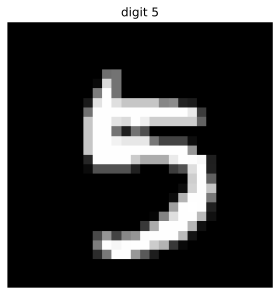

In [110]:
i = 3
plt.title(f'digit {labels[i]}')
plt.imshow(images[i, 0], cmap='gray')
plt.axis('off')
plt.show()



In [51]:
def train_epoch(
    network,
    train_loader,
    criterion,
    optimizer,
    LOGGING_INTERVAL
) -> float:
    """train `network` with `optimizer` for one epoch with data from `train_loader` to minimize `criterion`"""
    
    network.train()  # switch network submodules to train mode, e.g. it influences on batch-norm, dropout
    id = 0
    TOTAL_DONE = 0
    TOTAL_LOSS = 0
    for images, answers in train_loader:
        id += 1
        # 0. распакавываем данные на нужное устройство
        images, answers = images.to(device), answers.to(device) # чего? кажется этот код смещает нагрузку на видеокарту но у меня встройка и линукс так что оно в моем случае ниче не делает

        # 1. сбрасываем градиенты предыдущего батча
        optimizer.zero_grad() # YOUR CODE HERE

        # 2. прогоняем данные через нашу нейросеть
        logits = network(images)

        # 3. считаем loss
        loss = criterion(logits, answers) # кажется так надо передавать reduction
        # 4. считаем градиенты
        loss.backward() # YOUR CODE HERE
        TOTAL_LOSS += loss.item()

        # 5. обновляем параметры
        optimizer.step() # YOUR CODE HERE

        TOTAL_DONE += answers.size(0)

        if (id % LOGGING_INTERVAL == 0):
            loss_num = loss.item()
            _, my_answers = torch.max(logits, 1)
            num_predicted = (my_answers == labels).sum().item()
            total = answers.size(0)

            print(id, "ITERATIONS", "[", TOTAL_DONE, '/', DATASET_SIZE, '(', TOTAL_DONE / DATASET_SIZE, '%)]\t LOSS:', loss.item())
    return TOTAL_LOSS / id


In [65]:
#то же самое только тест

@torch.no_grad()
def val_epoch(
    network,
    val_loader,
    criterion
):
    """calculate loss and accuracy on validation data"""
    val_loss = 0
    correct = 0
    TOTAL_DONE = 0

    network.eval()  # switch network submodules to test mode
    for images, answers in val_loader:
        # 0. распакавываем данные на нужное устройство
        images, answers = images.to(device), answers.to(device) # YOUR CODE HERE

        # 1. прогоняем данные через нашу нейросеть
        logits = network(images) # YOUR CODE HERE

         # 2. получаем предсказание
        pred = torch.argmax(logits, dim=1) # YOUR CODE HERE

        # 3. логгируем лосс и accuracy
        val_loss += criterion(logits, answers).item()
        correct += torch.sum(pred == answers).item()

        TOTAL_DONE += answers.size(0)

    val_loss /= len(val_loader.dataset)
    val_accur = correct / len(val_loader.dataset)

    print(
        f'Test set: Avg. loss: {val_loss:.4f}',
        f'Accuracy: {correct}/{len(val_loader.dataset)}',
        f'({100. * val_accur:.0f}%)',
    )

    return val_loss, val_accur


In [84]:
def plot_training_summary(train_losses, val_losses, val_accuracies):
    """Plot training summary graphs"""
    plt.figure(figsize=(15, 5))
    
    # График loss
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    
    # График accuracy
    plt.subplot(1, 2, 2)
    plt.plot(val_accuracies, label='Validation Accuracy', color='green')
    plt.title('Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.savefig('training_summary.png', dpi=300, bbox_inches='tight')
    plt.show()

In [99]:
import os
from torch.utils.tensorboard import SummaryWriter

def train_val(
    network,
    n_epochs,
    criterion,
    train_loader,
    val_loader,
    LOGGING_INTERVAL
):
    """full cycle of neural network training"""

    writer = SummaryWriter('runs/mnist')
    os.makedirs("models", exist_ok=True)

    best_acc = 0
    train_losses = []
    val_losses = []
    val_accs = []

    CUR_LR = 0.1

    optimizer = optim.SGD(net.parameters(), lr=CUR_LR, momentum=0.9)


    #давайте раз в 10 эпох уменьшать LR в 4 раза

    val_epoch(network, val_loader, criterion)
    for epoch in range(1, n_epochs + 1):
        if (epoch % 10 == 1 and epoch != 1):
            CUR_LR /= 4
            optimizer = optim.SGD(net.parameters(), lr=CUR_LR, momentum=0.9)
        avg_train_loss = train_epoch(network, train_loader, criterion, optimizer, LOGGING_INTERVAL)
        train_losses.append(avg_train_loss)
        
        val_loss, val_accuracy = val_epoch(network, val_loader, criterion)
        val_losses.append(val_loss)
        val_accs.append(val_accuracy)
        
        writer.add_scalar('Loss/train', avg_train_loss, epoch)
        writer.add_scalar('Loss/val', val_loss, epoch)
        writer.add_scalar('Accuracy/val', val_accuracy, epoch)

        
        val_epoch(network, val_loader, criterion)

        if (val_accuracy > best_acc):
            best_acc = val_accuracy

            torch.save({
                'epoch': epoch,
                'model_state_dict': network.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'val_accuracy': val_accuracy,
                'val_loss': val_loss,
            }, 'models/best.pth')

            print("NEW RECORD", best_acc, '%')

            

    writer.close()
    
    plot_training_summary(train_losses, val_losses, val_accs)
    
    checkpoint = torch.load('models/best.pth')
    network.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    
    return train_losses, val_losses, val_accs


In [100]:


class LogReg(nn.Module):
    def __init__(self):
        super().__init__()

        self.flatten = nn.Flatten() # [X, 1, 28, 28] -> [X, 784] - преобразуемым данные в формат для линейной комбинации
        self.linear = nn.Linear(IMAGE_DIMENSION * IMAGE_DIMENSION, 10)

    def forward(self, x):
        
        x = self.flatten(x)

        return self.linear(x)



In [101]:

# создали нейронку
net = LogReg()
check_numel(net, 7850)



BEGIN TRAINING
Test set: Avg. loss: 0.0025 Accuracy: 1274/10000 (13%)
300 ITERATIONS [ 19200 / 60000 ( 0.32 %)]	 LOSS: 0.11169233173131943
600 ITERATIONS [ 38400 / 60000 ( 0.64 %)]	 LOSS: 0.8569425344467163
900 ITERATIONS [ 57600 / 60000 ( 0.96 %)]	 LOSS: 1.7516957521438599
Test set: Avg. loss: 0.0012 Accuracy: 8917/10000 (89%)
Test set: Avg. loss: 0.0012 Accuracy: 8917/10000 (89%)
NEW RECORD 0.8917 %
300 ITERATIONS [ 19200 / 60000 ( 0.32 %)]	 LOSS: 2.076035499572754
600 ITERATIONS [ 38400 / 60000 ( 0.64 %)]	 LOSS: 1.2487037181854248
900 ITERATIONS [ 57600 / 60000 ( 0.96 %)]	 LOSS: 1.161948800086975
Test set: Avg. loss: 0.0011 Accuracy: 8922/10000 (89%)
Test set: Avg. loss: 0.0011 Accuracy: 8922/10000 (89%)
NEW RECORD 0.8922 %
300 ITERATIONS [ 19200 / 60000 ( 0.32 %)]	 LOSS: 2.02514386177063
600 ITERATIONS [ 38400 / 60000 ( 0.64 %)]	 LOSS: 0.5766428112983704
900 ITERATIONS [ 57600 / 60000 ( 0.96 %)]	 LOSS: 1.6535310745239258
Test set: Avg. loss: 0.0014 Accuracy: 8784/10000 (88%)
Test s

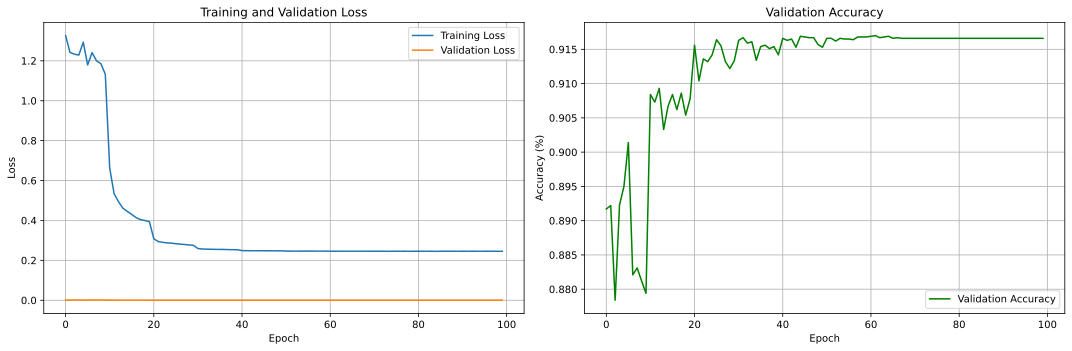

training finished


In [102]:
#тренируем

#выход нейронки - p_i = \sigma(out_i)

net = LogReg().to(device) # на GPU
criterion = nn.CrossEntropyLoss() # [LOSS_i = \sum_{i=0}^9{ln n_i * p_i - (1-n_i) * (1 - p_i)} - n_i = 1 если мы зашадали iую цифру
# берем такую функцию loss насколько я понял, чтобы там хорошие производные получались - ведь мы буквально берем производную по Loss чтобы найти где минимум ошибки
#out_i = bias_i + \sum{w_i * x_i} - w_i - вес, x_i - значение
#таким образом производные получатся:

#здесь будет вывод мб, пока не написал

# Оптимизатор - Stochastic Gradient Descent

print("BEGIN TRAINING")

train_val(net, 100, criterion, train_mnist_loader, val_mnist_loader, 300)
print("training finished")

In [97]:
# ! pip3 install tensorboard
from torch.utils.tensorboard import SummaryWriter


In [98]:
%load_ext tensorboard
%tensorboard --logdir .


In [25]:


# YOUR TRAINING FUNCTIONS HERE



In [26]:
# YOUR CODE HERE

In [27]:


# YOUR CODE HERE

